<a href="https://colab.research.google.com/github/aurrychan/dog-breed-classifier/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command
!pwd

/content/gdrive/My Drive/Kaggle
/content/gdrive/My Drive/Kaggle


In [335]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import shutil
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2

import tensorflow as tf

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


In [364]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications.resnet import ResNet50

#data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 10
img_height = 224
img_width = 224

data_dir = '/content/gdrive/My Drive/Kaggle/test/new_train'

train_ds = image_dataset_from_directory(    
  data_dir,
  validation_split=0.2,
  subset="training", 
  shuffle=True, 
  seed=123,
  label_mode = "categorical", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", 
  shuffle=True,
  seed=123,
  label_mode = "categorical" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names) 

Found 841 files belonging to 10 classes.
Using 673 files for training.
Found 841 files belonging to 10 classes.
Using 168 files for validation.
['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']


In [337]:
from tensorflow.data import AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [338]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 224, 224, 3)
(10, 10)


In [339]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),   
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
  ]
)

In [340]:
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers

num_classes = 10

my_new_model = Sequential(data_augmentation)                                               
                          
#my_new_model.add(Dropout(0.1))
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
my_new_model.add(Dropout(0.2))
my_new_model.add(Dense(128, activation='relu'))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[1].trainable = False

my_new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(my_new_model.summary())

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_82 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_40 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1290      
Total params: 23,851,274
Trainable params: 263,562
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [341]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./model_augmented.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.001)

In [342]:
epochs = 50

history = my_new_model.fit(
  x = train_ds,
  validation_data=val_ds,
  callbacks=[checkpoint, reduce_lr],
  batch_size = 10,
  epochs=epochs
)

Epoch 1/50
68/68 [==============================] - 7s 63ms/step - loss: 1.9033 - accuracy: 0.4008 - val_loss: 0.6937 - val_accuracy: 0.8452
Epoch 2/50
68/68 [==============================] - 3s 45ms/step - loss: 0.6592 - accuracy: 0.7819 - val_loss: 0.3458 - val_accuracy: 0.8810
Epoch 3/50
68/68 [==============================] - 3s 46ms/step - loss: 0.3675 - accuracy: 0.8524 - val_loss: 0.3879 - val_accuracy: 0.8750
Epoch 4/50
68/68 [==============================] - 3s 47ms/step - loss: 0.2534 - accuracy: 0.9100 - val_loss: 0.2905 - val_accuracy: 0.9226
Epoch 5/50
68/68 [==============================] - 3s 46ms/step - loss: 0.1640 - accuracy: 0.9443 - val_loss: 0.3228 - val_accuracy: 0.9167
Epoch 6/50
68/68 [==============================] - 3s 46ms/step - loss: 0.2101 - accuracy: 0.9219 - val_loss: 0.4848 - val_accuracy: 0.8690
Epoch 7/50
68/68 [==============================] - 3s 47ms/step - loss: 0.2790 - accuracy: 0.9046 - val_loss: 0.3176 - val_accuracy: 0.8988
Epoch 8/50
68

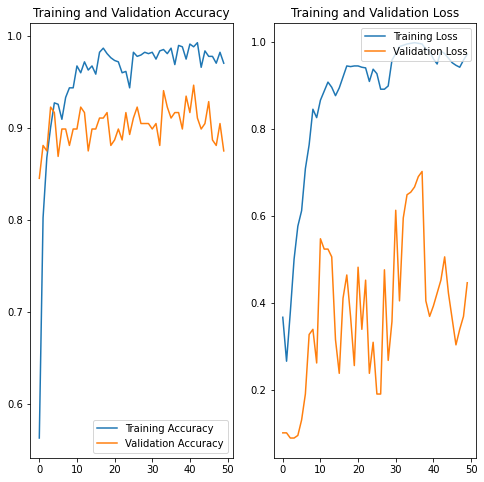

In [343]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [365]:
#Gathering metrics



val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", 
  shuffle=True,
  seed=123,
  label_mode = "categorical" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_model = tf.keras.models.load_model('/content/gdrive/My Drive/Kaggle/first_my_model_nostandard.h5')
print(test_model.summary())

test_eval = test_model.evaluate(val_ds)

Found 841 files belonging to 10 classes.
Using 168 files for validation.
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_79 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_39 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total params: 23,851,274
Trainable params: 263,562
Non-trainable params: 23,587,712
_________________________________________________________________
None
17/17 [================

In [369]:
preds = np.round(test_model.predict(val_ds), 0)

print(val_ds.class_names)
print(preds[0])


['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
